In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
import optuna  # For hyperparameter optimization


In [21]:
# ======================
# Step 1: Data Preprocessing
# ======================
def load_and_preprocess_data():
    # Load dataset (replace with your actual data loading)
    data = pd.read_csv('/content/teleconnect.csv')

    # Handle missing values in TotalCharges (empty strings -> NaN -> median)
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
    data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

    # Define features and target
    X = data.drop(['customerID', 'Churn'], axis=1)
    y = data['Churn'].map({'Yes': 1, 'No': 0})

    # Preprocessing pipeline
    numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
    categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService',
                          'MultipleLines', 'InternetService', 'OnlineSecurity',
                          'Contract', 'PaymentMethod']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])

    X_processed = preprocessor.fit_transform(X)
    return X_processed, y

X, y = load_and_preprocess_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-21-666a012f2eae>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


In [22]:
# ======================
# Step 2: Baseline ANN Model
# ======================
def create_baseline_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=SGD(learning_rate=0.01),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Recall()])
    return model

baseline_model = create_baseline_model(X_train.shape[1])
history = baseline_model.fit(X_train, y_train,
                           epochs=50,
                           batch_size=32,
                           validation_split=0.2,
                           verbose=1)

# Evaluate baseline
y_pred = (baseline_model.predict(X_test) > 0.5).astype(int)
print("=== Baseline Model (SGD) ===")
print(classification_report(y_test, y_pred))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5449 - loss: 0.6857 - recall: 0.5009 - val_accuracy: 0.7507 - val_loss: 0.5366 - val_recall: 0.0000e+00
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7277 - loss: 0.5551 - recall: 0.0287 - val_accuracy: 0.7595 - val_loss: 0.4844 - val_recall: 0.0463
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7484 - loss: 0.5159 - recall: 0.1510 - val_accuracy: 0.7897 - val_loss: 0.4550 - val_recall: 0.2598
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7641 - loss: 0.4890 - recall: 0.2858 - val_accuracy: 0.7950 - val_loss: 0.4394 - val_recall: 0.3559
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7817 - loss: 0.4590 - recall: 0.3899 - val_accuracy: 0.7968 - val_loss: 0.4313 - val_recall: 0.3879
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7662 - loss: 0.4858 - recall: 0.3692 - val_accuracy: 0.7924 - val_loss: 0.4271 - val_recall: 0.4199
Epoch 7/5

In [23]:
# Step 3: Optimized Models
# ======================
# Adam Optimizer
def create_adam_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Recall()])
    return model

adam_model = create_adam_model(X_train.shape[1])
adam_history = adam_model.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            validation_split=0.2,
                            verbose=0)  # Silent training

# RMSprop Optimizer
def create_rmsprop_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Recall()])
    return model

rmsprop_model = create_rmsprop_model(X_train.shape[1])
rmsprop_history = rmsprop_model.fit(X_train, y_train,
                                  epochs=50,
                                  batch_size=32,
                                  validation_split=0.2,
                                  verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# ======================
# Step 4: Hyperparameter Tuning with Optuna
# ======================
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'units': trial.suggest_categorical('units', [32, 64, 128]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5)
    }

    model = Sequential([
        Dense(params['units'], activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(params['dropout_rate']),
        Dense(params['units']//2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    history = model.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      validation_split=0.2,
                      callbacks=[early_stopping],
                      verbose=0)

    # Return validation accuracy
    return history.history['val_accuracy'][-1]

# Run optimization (comment out if short on time)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Reduce trials for faster execution

# Best model from Optuna
best_params = study.best_params
optimized_model = Sequential([
    Dense(best_params['units'], activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['units']//2, activation='relu'),
    Dense(1, activation='sigmoid')
])
optimized_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                      loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Recall()])
optimized_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)


[I 2025-05-15 21:53:58,058] A new study created in memory with name: no-name-c5869c47-44fd-4308-bcbe-fd5cdd4d32ca
[I 2025-05-15 21:54:24,573] Trial 0 finished with value: 0.8047915101051331 and parameters: {'learning_rate': 0.00012270808614132085, 'units': 64, 'dropout_rate': 0.34710292764182027}. Best is trial 0 with value: 0.8047915101051331.
[I 2025-05-15 21:54:35,777] Trial 1 finished with value: 0.8030168414115906 and parameters: {'learning_rate': 0.003905813321742777, 'units': 64, 'dropout_rate': 0.19025616232047576}. Best is trial 0 with value: 0.8047915101051331.
[I 2025-05-15 21:54:48,955] Trial 2 finished with value: 0.7994676232337952 and parameters: {'learning_rate': 0.005028444735597335, 'units': 64, 'dropout_rate': 0.1732845740757858}. Best is trial 0 with value: 0.8047915101051331.
[I 2025-05-15 21:54:59,983] Trial 3 finished with value: 0.8030168414115906 and parameters: {'learning_rate': 0.000984020111137481, 'units': 32, 'dropout_rate': 0.33014021208275396}. Best is t

In [25]:
# ======================
# Step 5: Evaluation & Comparison
# ======================
def evaluate_model(model, X_test, y_test, name):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    return classification_report(y_test, y_pred, output_dict=True)

In [26]:
# Compare all models
baseline_report = evaluate_model(baseline_model, X_test, y_test, "Baseline (SGD)")
adam_report = evaluate_model(adam_model, X_test, y_test, "Adam Optimizer")
rmsprop_report = evaluate_model(rmsprop_model, X_test, y_test, "RMSprop Optimizer")
optimized_report = evaluate_model(optimized_model, X_test, y_test, "Optimized (Optuna)")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Baseline (SGD) ===
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1036
           1       0.68      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Adam Optimizer ===
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.66      0.53      0.59       373

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== RMSprop Optimizer ===
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1036
           1       0.68      0.45      0.54  

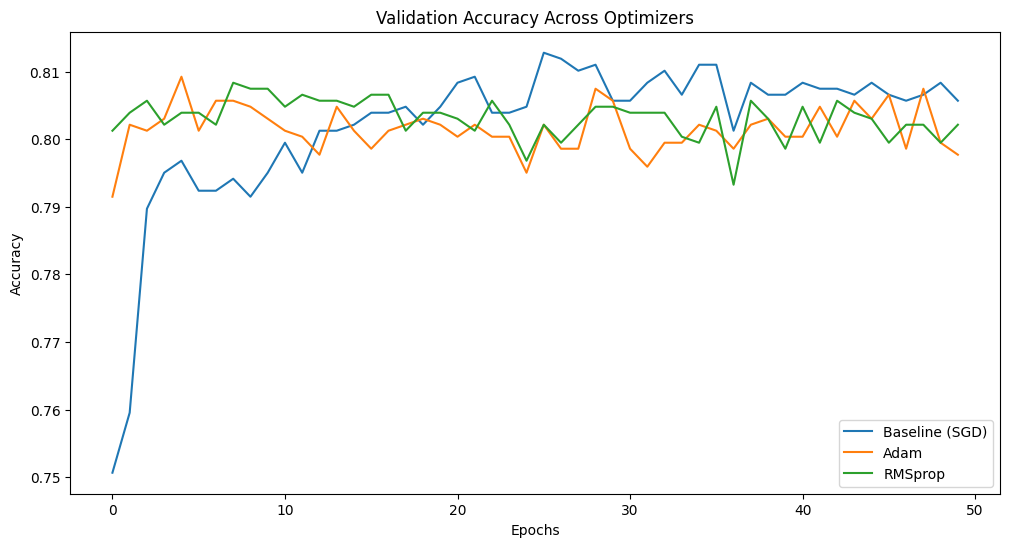

In [27]:
# ======================
# Visualization
# ======================
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_accuracy'], label='Baseline (SGD)')
plt.plot(adam_history.history['val_accuracy'], label='Adam')
plt.plot(rmsprop_history.history['val_accuracy'], label='RMSprop')
plt.title('Validation Accuracy Across Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()